# Imports

In [1]:
# Imports
import numpy as np
import mne
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn.decomposition import FastICA
from scipy.stats import pearsonr
import seaborn as sns
import pywt
from scipy import signal as sig
import pandas as pd
from scipy.stats import entropy
from scipy import stats
import scipy.fftpack as fft

# Data Loading functions

In [2]:
# Data Loading functions
def read_xml(xml_filename):
    """ Parses the XML file and extracts events, sleep stages, epoch length, and annotations. """
    try:
        tree = ET.parse(xml_filename)
        root = tree.getroot()
    except Exception as e:
        raise RuntimeError(f"Failed to read XML file {xml_filename}: {e}")

    # Extract epoch length
    epoch_length = int(root.find("EpochLength").text)

    # Define sleep stage mapping
    stage_mapping = {
        "SDO:NonRapidEyeMovementSleep-N1": 4,
        "SDO:NonRapidEyeMovementSleep-N2": 3,
        "SDO:NonRapidEyeMovementSleep-N3": 2,
        "SDO:NonRapidEyeMovementSleep-N4": 1,
        "SDO:RapidEyeMovementSleep": 0,  # REM sleep
        "SDO:WakeState": 5               # Wake state
    }

    # Initialize storage
    events = []
    stages = []
    
    # Parse events
    for scored_event in root.find("ScoredEvents"):
        event_concept = scored_event.find("EventConcept").text
        start = float(scored_event.find("Start").text)
        duration = float(scored_event.find("Duration").text)

        # Check if event is a sleep stage
        if event_concept in stage_mapping:
            stages.extend([stage_mapping[event_concept]] * int(duration))
        else:
            # Extract additional attributes if available
            spo2_nadir = scored_event.find("SpO2Nadir")
            spo2_baseline = scored_event.find("SpO2Baseline")
            desaturation = scored_event.find("Desaturation")

            event_data = {
                "EventConcept": event_concept,
                "Start": start,
                "Duration": duration,
                "SpO2Nadir": float(spo2_nadir.text) if spo2_nadir is not None else None,
                "SpO2Baseline": float(spo2_baseline.text) if spo2_baseline is not None else None,
                "Desaturation": float(desaturation.text) if desaturation is not None else None
            }
            events.append(event_data)

    return events, stages, epoch_length, bool(events)

# Preprocessing functions

In [3]:
from scipy.signal import butter, filtfilt, iirnotch

In [4]:
# Preprocessing functions

def select_significant_signal(stages):
    """ Point out the first and last epoch containing relevant information """
    start_epoch = next((i for i, x in enumerate(stages) if x != 5), -1) // 30 # First epoch that doesn't belong to the initial 'Wake Stage'
    end_epoch = next((len(stages) - 1 - i for i, x in enumerate(reversed(stages)) if x != 5), -1) // 30 # Last Epoch of the sleeping phase, before the final 'Wake' of the patient
    return start_epoch, end_epoch

def ICA_perform(eeg_data, eegsec_data, eog_L_data, eog_R_data, ecg_data, emg_data):
    """ 
    Performs ICA on the EEGs signals
    
    return: the pair of ICA cleaned EEGs signals
    
    """
    # Stack EEG and artifact-related signals
    X = np.vstack([eeg_data, eegsec_data, eog_L_data, eog_R_data, ecg_data, emg_data])  # (6, n_samples)
    X = X.T  # (n_samples, n_channels)

    # Apply ICA
    ica = FastICA(n_components=X.shape[1], random_state=42)
    X_transformed = ica.fit_transform(X)  # (n_samples, n_components)
    mixing_matrix = ica.mixing_  # (n_components, n_channels)

    # Reference signals (artifacts)
    artifact_refs = np.vstack([eog_L_data, eog_R_data, ecg_data, emg_data]).T

    # Compute and Plot Correlation Matrix 
    n_components = X_transformed.shape[1]
    n_artifacts = artifact_refs.shape[1]
    correlation_matrix = np.zeros((n_components, n_artifacts))

    for i in range(n_components):
        for j in range(n_artifacts):
            correlation_matrix[i, j], _ = pearsonr(X_transformed[:, i], artifact_refs[:, j])

    # ----- Identify components with correlation >= threshold -----
    artifact_indices = []
    threshold = 0.6

    for i in range(n_components):
        for j in range(n_artifacts):
            if abs(correlation_matrix[i, j]) >= threshold:
                artifact_indices.append(i)
                break

    artifact_indices = list(set(artifact_indices))

    # ----- Zero out artifact components -----
    X_cleaned = X_transformed.copy()
    X_cleaned[:, artifact_indices] = 0

    # Reconstruct cleaned signals
    X_reconstructed = X_cleaned @ mixing_matrix.T
    X_reconstructed = X_reconstructed.T

    # Extract cleaned EEGs
    cleaned_eeg = X_reconstructed[0]
    cleaned_eegsec = X_reconstructed[1]

    return cleaned_eeg, cleaned_eegsec

# ==== FILTER HELPERS ====

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return b, a

def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff / nyq, btype='high')
    return b, a

def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    if cutoff >= nyq:
        cutoff = nyq - 1  # adjust to safe margin
    b, a = butter(order, cutoff / nyq, btype='low')
    return b, a

def notch_filter(signal, fs, freq=50.0, Q=30):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal)

def apply_filters(signal, fs, signal_type):
    # Step 1: Remove baseline drift
    if signal_type in ['EEG', 'EOG', 'ECG']:
        b, a = butter_highpass(0.5, fs)
    elif signal_type == 'EMG':
        b, a = butter_highpass(10, fs)
    signal = filtfilt(b, a, signal)

    # Step 2: Remove high-frequency noise
    if signal_type in ['EEG', 'EOG', 'ECG']:
        b, a = butter_lowpass(40, fs)
    elif signal_type == 'EMG':
        b, a = butter_lowpass(100, fs)
    signal = filtfilt(b, a, signal)

    # Step 3: Remove powerline noise (e.g., 60 Hz)
    signal = notch_filter(signal, fs, freq=60.0)  

    return signal

# Utility functions

In [5]:
# Utility functions
def extract_artifact_idx(events):
    """Extart the indexes of epochs containing artifacts in a patient xml file"""
    time_artifact = []
    for event in events:
        start_idx = int(event["Start"])
        end_idx = start_idx + int(event["Duration"])
        if event["EventConcept"] == "SignalArtifactEvent":
            time_artifact.append(start_idx)
            time_artifact.append(end_idx)
            
    epochs_artifacts = []
    for t in time_artifact:
        epochs_artifacts.append(t//30)

    epochs_artifacts = np.array(epochs_artifacts)
    epochs_artifacts = epochs_artifacts - start_epoch
    return epochs_artifacts

# Features Extraction functions

In [ ]:
# EEG Features Extraction functions
def extract_statistical_features_eeg(signal):
    """ Extracts time domain & statistical features """
    # Zero-crossings
    zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()
    
    # Hjorth parameters
    first_derivative = np.diff(signal)
    second_derivative = np.diff(first_derivative)
    
    activity = np.var(signal)
    mobility = np.sqrt(np.var(first_derivative) / activity) if activity != 0 else 0
    complexity = (
        np.sqrt(np.var(second_derivative) / np.var(first_derivative))
        if np.var(first_derivative) != 0 else 0
    )

    features = {
        "mean": np.mean(signal),
        "median": np.median(signal),
        "variance": activity,
        "std": np.std(signal),
        "skewness": stats.skew(signal),
        "kurtosis": stats.kurtosis(signal),
        "zero_crossings": zero_crossings,
        "hjorth_activity": activity,
        "hjorth_mobility": mobility,
        "hjorth_complexity": complexity
    }
    return pd.DataFrame([features])

def extract_spectral_features_eeg(signal, sfreq):
    """ Extracts Spectral Complexity Measures """
    # Calculate PSD
    f, Pxx = sig.welch(signal, fs=sfreq, nperseg=min(len(signal), sfreq*4))

    # Normalize PSD to calculate entropy (like a probability distribution)
    Pxx_norm = Pxx / np.sum(Pxx)

    # Calculate entropy (higher entropy = more complex/random signal)
    spectral_entropy = entropy(Pxx_norm)

    # Spectral edge frequency (frequency below which X% of power resides) 50% (median frequency) and 95% spectral edge
    # Calculate cumulative sum of power
    cumsum_pxx = np.cumsum(Pxx) / np.sum(Pxx)

    # Find frequencies at 50% and 95% power
    idx_50 = np.argmax(cumsum_pxx >= 0.5)
    idx_95 = np.argmax(cumsum_pxx >= 0.95)

    spectral_edge_50 = f[idx_50]
    spectral_edge_95 = f[idx_95]

    features = {
        "spectral_entropy": spectral_entropy,
        "spectral_edge_50": spectral_edge_50, 
        "spectral_edge_95": spectral_edge_95
    }
    return pd.DataFrame([features])

def extract_wavelet_features_eeg(signal, sfreq):
        features = {}
        # perform a DWT on the cleaned eeg_data to extract frequency bands on the epoch
        wavelet = 'db4' # Define wavelet and decomposition level
        level = 6  # Decomposition level

        # Frequency bands for DWT decomposition with sfreq=125Hz
        # Note: These are approximate ranges due to the nature of wavelet transforms
        # Actual passbands are not as sharp as in FIR/IIR filters
        #
        # At sampling rate of 125Hz:
        # - Nyquist frequency: 62.5 Hz
        # - DWT Level 1 detail coefficients (cD1): ~31.25-62.5 Hz (gamma)
        # - DWT Level 2 detail coefficients (cD2): ~15.625-31.25 Hz (beta)
        # - DWT Level 3 detail coefficients (cD3): ~7.8125-15.625 Hz (alpha/spindles)
        # - DWT Level 4 detail coefficients (cD4): ~3.90625-7.8125 Hz (theta)
        # - DWT Level 5 detail coefficients (cD5): ~1.953125-3.90625 Hz (delta)
        # - DWT Level 6 detail coefficients (cD6): ~0.9765625-1.953125 Hz (slow delta)
        # - DWT Level 6 approximation coefficients (cA6): ~0-0.9765625 Hz (very slow oscillations)

        # Perform DWT on cleaned EEG data epoch
        coeffs = pywt.wavedec(signal, wavelet, level=level)

        # Extract coefficients (1 approximation + 6 details)
        cA6, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

        # Create zero arrays with the same shape as the coefficients
        zero_cA6 = np.zeros_like(cA6)
        zero_cD6 = np.zeros_like(cD6)
        zero_cD5 = np.zeros_like(cD5)
        zero_cD4 = np.zeros_like(cD4)
        zero_cD3 = np.zeros_like(cD3)
        zero_cD2 = np.zeros_like(cD2)
        zero_cD1 = np.zeros_like(cD1)

        # Reconstruct each frequency band
        # For slow delta band (0-1 Hz): Use cA6
        coeffs_slow_delta = [cA6, zero_cD6, zero_cD5, zero_cD4, zero_cD3, zero_cD2, zero_cD1]
        slow_delta_band = pywt.waverec(coeffs_slow_delta, wavelet)[:len(signal)]

        # For delta band (1-4 Hz): Use cD6 (1-2 Hz) and cD5 (2-4 Hz)
        coeffs_delta = [zero_cA6, cD6, cD5, zero_cD4, zero_cD3, zero_cD2, zero_cD1]
        delta_band = pywt.waverec(coeffs_delta, wavelet)[:len(signal)]

        # For theta band (4-8 Hz): Use cD4
        coeffs_theta = [zero_cA6, zero_cD6, zero_cD5, cD4, zero_cD3, zero_cD2, zero_cD1]
        theta_band = pywt.waverec(coeffs_theta, wavelet)[:len(signal)]

        # For alpha/spindle band (8-16 Hz): Use cD3
        coeffs_alpha = [zero_cA6, zero_cD6, zero_cD5, zero_cD4, cD3, zero_cD2, zero_cD1]
        alpha_spindle_band = pywt.waverec(coeffs_alpha, wavelet)[:len(signal)]

        # For beta band (16-32 Hz): Use cD2
        coeffs_beta = [zero_cA6, zero_cD6, zero_cD5, zero_cD4, zero_cD3, cD2, zero_cD1]
        beta_band = pywt.waverec(coeffs_beta, wavelet)[:len(signal)]

        # For gamma band (32-62.5 Hz): Use cD1
        coeffs_gamma = [zero_cA6, zero_cD6, zero_cD5, zero_cD4, zero_cD3, zero_cD2, cD1]
        gamma_band = pywt.waverec(coeffs_gamma, wavelet)[:len(signal)]

        # Initialize arrays to store PSD values for each band and epoch
        # band_names = ['Slow Delta (0-1 Hz)', 'Delta (1-4 Hz)', 'Theta (4-8 Hz)', 'Alpha+Spindles (8-16 Hz)', 'Beta (16-32 Hz)', 'Gamma (32-62.5 Hz)']
        band_names_short = ['slow_delta', 'delta', 'theta', 'alpha', 'beta', 'gamma']
        all_bands = [slow_delta_band, delta_band, theta_band, alpha_spindle_band, beta_band, gamma_band]

        # Create dictionary to store band powers by epoch
        band_powers = {band_name: [] for band_name in band_names_short}

        # Calculate band powers for this epoch
        for band_idx, (band, band_name) in enumerate(zip(all_bands, band_names_short)): 

            # Calculate PSD for this band/epoch using Welch's method
            f, Pxx = sig.welch(band, fs=sfreq, nperseg=min(len(band), sfreq*4))
            
            # Calculate total power in band (area under PSD curve)
            total_power = np.sum(Pxx)
            band_powers[band_name].append(total_power)

        # Convert lists to numpy arrays for easier manipulation
        for band_name in band_names_short:
            band_powers[band_name] = np.array(band_powers[band_name])

        # Absolute and Relative Powers
        for band_name in band_names_short:
            features['absolute_power' + ' ' + band_name] = band_powers[band_name]

        # Calculate relative power for each band
        for band_name in band_names_short:
            features['relative_power' + ' ' + band_name] = band_powers[band_name] 

        # Power Ratios - Calculate ratios between bands
        ratio_pairs = [
            ('slow_delta', 'delta'),    # Slow delta to delta ratio
            ('delta', 'theta'),         # Delta to theta ratio
            ('theta', 'alpha'),         # Theta to alpha ratio
            ('alpha', 'beta'),          # Alpha to beta ratio
            ('delta', 'beta'),          # Delta to beta ratio (often used in sleep studies)
            ('theta', 'beta'),          # Theta to beta ratio (attention/concentration)
            ('slow_delta', 'gamma'),    # Slow delta to gamma ratio
            ('delta', 'gamma')          # Delta to gamma ratio
        ]

        for band1, band2 in ratio_pairs:
            ratio_name = f"{band1}_to_{band2}"
            # Avoid division by zero with small epsilon
            features['power_ratios' + ' ' + ratio_name] = band_powers[band1] / (band_powers[band2] + 1e-10)

        # Extract Spindles
        # Use the alpha_spindle_band directly instead of applying additional filtering
        spindle_band = alpha_spindle_band

        # Calculate the signal envelope
        spindle_envelope = np.abs(sig.hilbert(spindle_band))

        threshold_factor_lower = 1.0
        threshold_factor_upper = 5.0
        min_duration = 0.4
        max_duration = 2.0

        # Define a threshold based on the mean envelope
        mean_envelope = np.mean(spindle_envelope)
        lower_threshold = threshold_factor_lower * mean_envelope
        upper_threshold = threshold_factor_upper * mean_envelope

        # 3) Create a mask that is True only where envelope is between lower and upper thresholds
        valid_mask = (spindle_envelope >= lower_threshold) & (spindle_envelope <= upper_threshold)

        # 4) Scan the mask to detect contiguous segments that qualify as spindles
        spindles = []
        n_samples = len(spindle_band)
        for j in range(n_samples):
            if valid_mask[j]:
                start = j
                # Move forward while we remain within valid_mask == True
                while j < n_samples and valid_mask[j]:
                    j += 1
                end = j
                duration = (end - start) / sfreq

                # 5) Check duration constraints
                if min_duration <= duration <= max_duration:
                    spindles.append((start, end, duration))

        # Convert to spindles per minute (30-second epochs = 2 epochs per minute)
        num_spindles = len(spindles)
        spindle_density = 2*num_spindles  # per minute
        features['spindle_density'] = spindle_density

        return pd.DataFrame(features)


In [7]:
# ECG Features Extraction functions
# Time-domain features for ECG
def extract_time_features_ecg(signal):
    rms = np.sqrt(np.mean(signal ** 2))
    mad = np.mean(np.abs(signal - np.mean(signal)))
    
    # Hjorth parameters
    first_derivative = np.diff(signal)
    second_derivative = np.diff(first_derivative)
    
    activity = np.var(signal)
    mobility = np.sqrt(np.var(first_derivative) / activity) if activity != 0 else 0
    complexity = (
        np.sqrt(np.var(second_derivative) / np.var(first_derivative))
        if np.var(first_derivative) != 0 else 0
    )
    
    return pd.DataFrame([{
        "rms": rms,
        "mad": mad,
        "hjorth_activity": activity,
        "hjorth_mobility": mobility,
        "hjorth_complexity": complexity
    }])

# Statistical features for ECG
def extract_statistical_features_ecg(signal):
    zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()  # Optional for ECG

    return pd.DataFrame([{
        "mean": np.mean(signal),
        "median": np.median(signal),
        "variance": np.var(signal),
        "std": np.std(signal),
        "skewness": stats.skew(signal),
        "kurtosis": stats.kurtosis(signal),
        "zero_crossings": zero_crossings
    }])

# Frequency-domain features
def extract_frequency_features_ecg(signal, sfreq):
    freqs = fft.fftfreq(len(signal), d=1/sfreq)
    power_spectrum = np.abs(fft.fft(signal)) ** 2
    lf_band = (0.04, 0.15)
    hf_band = (0.15, 0.4)
    lf_power = np.sum(power_spectrum[(freqs >= lf_band[0]) & (freqs < lf_band[1])])
    hf_power = np.sum(power_spectrum[(freqs >= hf_band[0]) & (freqs < hf_band[1])])
    lf_hf_ratio = lf_power / (hf_power + 1e-6)
    features = {
        "lf_power": lf_power,
        "hf_power": hf_power,
        "lf_hf_ratio": lf_hf_ratio
    }
    return pd.DataFrame([features])

# Wavelet features
def extract_wavelet_features_ecg(signal):
    # Define parameters
    wavelet = 'db4'  # Daubechies wavelet (common for ECG)
    level = 4  # Decomposition level
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = {}
    for i, c in enumerate(coeffs):
        band = f"C{i}" if i == 0 else f"D{i}"  # C0 = Approximation, D1...Dn = Details
        features[f"{band}_mean"] = np.mean(c)
        features[f"{band}_std"] = np.std(c)
        features[f"{band}_energy"] = np.sum(np.square(c))
        features[f"{band}_entropy"] = stats.entropy(np.abs(c) + 1e-6)
    return pd.DataFrame([features])

# Extracting features over all patients & over all epochs

In [8]:
# Process All patients : Preprocess + Features extraction

# Create a feature matrix that contains all patients epochs features
all_patients_features = []

# Let's Loop Over all patients files 
for k in range(1,11):
    #
    ### --- 1.LOAD DATA : Load EDF & xml file for patient R{i} --- 
    #
    ## Extract raw edf & read xml file
    edf_path = f"Data/R{k}.edf"  
    raw = mne.io.read_raw_edf(edf_path, preload=True)

    xml_path = f"Data/R{k}.xml"  
    events, stages, epoch_length, has_annotations = read_xml(xml_path)

    ## Get metadata
    n_channels = len(raw.ch_names)
    sfreq = int(raw.info['sfreq'])  # Sampling frequency

    # Define a 30-second epoch
    epoch_duration = 30  # seconds
    epoch_samples = sfreq * epoch_duration

    ## Select the segment of the signal that contains the sleeping phase (clean pre & post 'Wake' stage)
    start_epoch, end_epoch = select_significant_signal(stages)
    num_epochs = end_epoch - start_epoch + 1 # Number of epoch in the extracted segment

    start_sample = start_epoch * epoch_samples
    end_sample = (end_epoch + 1) * epoch_samples

    # Extract the sleeping phase from signals 
    data, times = raw[:, start_sample:end_sample]
    eeg_data = data[7]
    eegsec_data = data[2]
    eog_L_data = data[5]
    eog_R_data = data[6]
    ecg_data = data[3]
    emg_data = data[4]
    
    #
    ### --- 2. PREPROCESS SIGNALS ---
    #
    ## Apply basic filter to the extracted signals
    eeg_data = apply_filters(eeg_data, sfreq,'EEG')
    eegsec_data = apply_filters(eegsec_data, sfreq,'EEG')
    eog_L_data = apply_filters(eog_L_data, sfreq,'EOG')
    eog_R_data = apply_filters(eog_R_data, sfreq,'EOG')
    ecg_data = apply_filters(ecg_data, sfreq,'ECG')
    emg_data = apply_filters(emg_data, sfreq,'EMG')
    

    ### Perform ICA preprocessing
    cleaned_eeg, cleaned_eegsec = ICA_perform(eeg_data, eegsec_data, eog_L_data, eog_R_data, ecg_data, emg_data)

    #
    ### --- 3. EXTRACTING FEATURES --- 
    #
    print(f'---------------------------- Extracting features for patient R{k} ----------------------------')

    ## Extract the indexes of epochs containing artifacts
    epochs_artifacts_idx = extract_artifact_idx(events)

    all_epochs_features = []
    for i in range(num_epochs):
        if i in epochs_artifacts_idx: # If the epoch contains artifacts, it is skipped
            continue
        start_sample = i * epoch_samples
        end_sample = start_sample + epoch_samples

        id = {}
        id['patient_id'] = k
        id['epoch_id'] = i
        id = pd.DataFrame([id])

        ##-------------------------------
        ## --- EEG features extraction---
        ##-------------------------------
        # Extract the corresponding eeg epoch
        eeg_epoch = cleaned_eeg[start_sample:end_sample]

        # Time domain features
        df_time_eeg = extract_statistical_features_eeg(eeg_epoch)
        # Spectral features
        df_spectral_eeg = extract_spectral_features_eeg(eeg_epoch, sfreq)
        # Wavelet features
        df_wavelet_eeg = extract_wavelet_features_eeg(eeg_epoch, sfreq)

        # Rename for easier identification when use of the .cvs: tag with 'EEG'
        df_time_eeg.columns = ['EEG ' + col for col in df_time_eeg.columns]
        df_spectral_eeg.columns = ['EEG ' + col for col in df_spectral_eeg.columns]
        df_wavelet_eeg.columns = ['EEG ' + col for col in df_wavelet_eeg.columns]

        ##-------------------------------
        ## --- ECG features extraction---
        ##-------------------------------
        # Extract the corresponding eeg epoch
        ecg_epoch = ecg_data[start_sample:end_sample]

        # Statisticall domain
        df_stat_ecg = extract_statistical_features_ecg(ecg_epoch)
        # Time domain
        df_time_ecg = extract_time_features_ecg(ecg_epoch)
        # Spectral domain
        df_spectral_ecg = extract_frequency_features_ecg(ecg_epoch, sfreq)
        # Wavelet
        df_wavelet_ecg = extract_wavelet_features_ecg(ecg_epoch)

        # Rename for easier identification when use of the .cvs: tag with 'EEG'
        df_time_ecg.columns = ['ECG ' + col for col in df_time_ecg.columns]
        df_stat_ecg.columns = ['ECG ' + col for col in df_stat_ecg.columns]
        df_spectral_ecg.columns = ['ECG ' + col for col in df_spectral_ecg.columns]
        df_wavelet_ecg.columns = ['ECG ' + col for col in df_wavelet_ecg.columns]

        ## --- Extract the corresponding labels ---
        sleep_stage = {}
        epoch_label = stages[30*(start_epoch + i) + 15]
        if epoch_label > 1:
            epoch_label -= 1
        sleep_stage['label'] = epoch_label
        label = pd.DataFrame([sleep_stage])

        # Create a pandas DataFrame with all the extracted features
        epoch_features_df = pd.concat([id, df_time_eeg, df_spectral_eeg, df_wavelet_eeg, df_time_ecg, df_stat_ecg, df_spectral_ecg, df_wavelet_ecg, label], axis=1)
        all_epochs_features.append(epoch_features_df)

    # Concatenate all epochs into one DataFrame
    features_df = pd.concat(all_epochs_features, ignore_index=True)

    # Identify all columns that contain "relative_power"
    relative_cols = [col for col in features_df.columns if 'relative_power' in col]

    # Normalize each row so that the sum of the relative_power values equals 1
    features_df[relative_cols] = features_df[relative_cols].div(features_df[relative_cols].sum(axis=1), axis=0)


    # Add to all_patients 
    all_patients_features.append(features_df)

all_features_df = pd.concat(all_patients_features, ignore_index=True)
all_features_df.to_csv("all_features.csv", index=False)


Extracting EDF parameters from c:\Users\m-far\OneDrive\Documents\KTH\CM2013\Project\python_code\Data\R1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4064999  =      0.000 ... 32519.992 secs...


C:\Users\m-far\AppData\Local\Temp\ipykernel_72752\1288530726.py:13: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


---------------------------- Extracting features for patient R1 ----------------------------
Extracting EDF parameters from c:\Users\m-far\OneDrive\Documents\KTH\CM2013\Project\python_code\Data\R2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4046249  =      0.000 ... 32369.992 secs...


C:\Users\m-far\AppData\Local\Temp\ipykernel_72752\1288530726.py:13: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


---------------------------- Extracting features for patient R2 ----------------------------
Extracting EDF parameters from c:\Users\m-far\OneDrive\Documents\KTH\CM2013\Project\python_code\Data\R3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3933749  =      0.000 ... 31469.992 secs...


C:\Users\m-far\AppData\Local\Temp\ipykernel_72752\1288530726.py:13: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


---------------------------- Extracting features for patient R3 ----------------------------
Extracting EDF parameters from c:\Users\m-far\OneDrive\Documents\KTH\CM2013\Project\python_code\Data\R4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3281249  =      0.000 ... 26249.992 secs...


C:\Users\m-far\AppData\Local\Temp\ipykernel_72752\1288530726.py:13: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


---------------------------- Extracting features for patient R4 ----------------------------
Extracting EDF parameters from c:\Users\m-far\OneDrive\Documents\KTH\CM2013\Project\python_code\Data\R5.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4064999  =      0.000 ... 32519.992 secs...


C:\Users\m-far\AppData\Local\Temp\ipykernel_72752\1288530726.py:13: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


---------------------------- Extracting features for patient R5 ----------------------------
Extracting EDF parameters from c:\Users\m-far\OneDrive\Documents\KTH\CM2013\Project\python_code\Data\R6.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4064999  =      0.000 ... 32519.992 secs...


C:\Users\m-far\AppData\Local\Temp\ipykernel_72752\1288530726.py:13: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


---------------------------- Extracting features for patient R6 ----------------------------
Extracting EDF parameters from c:\Users\m-far\OneDrive\Documents\KTH\CM2013\Project\python_code\Data\R7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3446249  =      0.000 ... 27569.992 secs...


C:\Users\m-far\AppData\Local\Temp\ipykernel_72752\1288530726.py:13: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


---------------------------- Extracting features for patient R7 ----------------------------
Extracting EDF parameters from c:\Users\m-far\OneDrive\Documents\KTH\CM2013\Project\python_code\Data\R8.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3596249  =      0.000 ... 28769.992 secs...


C:\Users\m-far\AppData\Local\Temp\ipykernel_72752\1288530726.py:13: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


---------------------------- Extracting features for patient R8 ----------------------------
Extracting EDF parameters from c:\Users\m-far\OneDrive\Documents\KTH\CM2013\Project\python_code\Data\R9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4072499  =      0.000 ... 32579.992 secs...


C:\Users\m-far\AppData\Local\Temp\ipykernel_72752\1288530726.py:13: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


---------------------------- Extracting features for patient R9 ----------------------------
Extracting EDF parameters from c:\Users\m-far\OneDrive\Documents\KTH\CM2013\Project\python_code\Data\R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4064999  =      0.000 ... 32519.992 secs...


C:\Users\m-far\AppData\Local\Temp\ipykernel_72752\1288530726.py:13: RuntimeWarning: Invalid measurement date encountered in the header.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


---------------------------- Extracting features for patient R10 ----------------------------


In [9]:
all_features_df.head()

,patient_id,epoch_id,EEG mean,EEG median,EEG variance,EEG std,EEG skewness,EEG kurtosis,EEG zero_crossings,EEG hjorth_activity,...,ECG D2_entropy,ECG D3_mean,ECG D3_std,ECG D3_energy,ECG D3_entropy,ECG D4_mean,ECG D4_std,ECG D4_energy,ECG D4_entropy,label
0,1,0,6.352381e-08,2.815589e-07,3.342709e-10,0.000018,-0.134420,0.948275,1234,3.342709e-10,...,5.448418,-1.553501e-06,0.000040,0.000002,5.897686,4.625747e-10,0.000012,2.835765e-07,6.800004,3
1,1,1,-1.450482e-08,-1.189939e-07,8.545464e-11,0.000009,-0.117992,0.597043,751,8.545464e-11,...,5.505685,1.622367e-07,0.000046,0.000002,5.821377,-3.046745e-10,0.000012,2.842478e-07,6.800383,2
2,1,2,3.979427e-08,-5.594852e-07,1.761963e-10,0.000013,0.920256,15.951797,520,1.761963e-10,...,5.446850,-3.731522e-07,0.000046,0.000002,5.810086,-1.079135e-09,0.000012,2.756767e-07,6.765936,2
3,1,3,-4.668347e-08,-3.348892e-07,2.451662e-10,0.000016,0.966922,5.759099,454,2.451662e-10,...,5.461162,-4.473762e-07,0.000045,0.000002,5.802308,2.851219e-10,0.000012,2.862285e-07,6.752681,2
4,1,4,2.099871e-08,-7.645831e-07,3.531367e-10,0.000019,0.689169,8.172782,434,3.531367e-10,...,5.437166,1.543726e-07,0.000045,0.000002,5.826337,6.680825e-10,0.000013,3.241440e-07,6.684033,4


In [ ]:
# Train a classifier based on the extracted data

c:\Users\m-far\anaconda3\envs\CM2013\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:46:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.74      0.81       222
           1       0.85      0.80      0.83       324
           2       0.78      0.90      0.84       759
           3       0.50      0.12      0.19        52
           4       0.74      0.70      0.72       246

    accuracy                           0.80      1603
   macro avg       0.75      0.65      0.68      1603
weighted avg       0.80      0.80      0.79      1603

F1 Score (macro): 0.6756
F1 Score (weighted): 0.7920


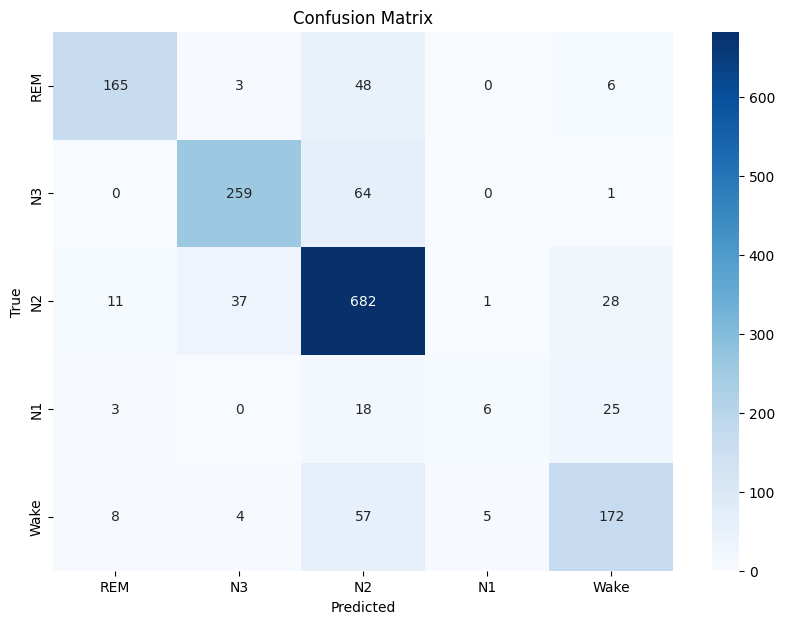

In [ ]:
# Learning from features 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Load CSV
df = pd.read_csv("all_features.csv")

# Drop unwanted columns
df = df.drop(columns=['patient_id', 'epoch_id'])
df = df.loc[:, ~df.columns.str.contains('relative_power')] #scaler.fittransfrom is going to fit the data anyways

# Separate features and target
X = df.drop(columns=['label'])
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# F1 scores
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"F1 Score (weighted): {f1_weighted:.4f}")

# Confusion Matrix
label_names = ["REM", "N3", "N2", "N1", "Wake"]
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
